# Choosing the location for oil well

Glavrosgosneft Mining Company. We need to decide where to drill a new well.

We were provided with oil samples in three regions: in each 10,000 fields, where the quality of oil and the volume of its reserves were measured. It is necessary to build a machine learning model that will help determine the region where mining will bring the greatest profit. To analyze possible profits and risks, we will use the *Bootstrap technique.*

Steps to select a location:

- They are looking for deposits in the selected region, the values of the signs are determined for each;
- Build a model and estimate the volume of stocks;
- - Choose the deposits with the highest estimates of values. The number of deposits depends on the company's budget and the cost of developing one well;
- The profit is equal to the total profit of the selected fields.

According to the documentation provided below is a breakdown of the columns of the table.

1. id — the unique identifier of the well;
2. f0, f1, f2 — three signs of dots (no matter what they mean, but the signs themselves are significant);
3. product — the volume of reserves in the well (thousand barrels).

Task conditions:

- The budget for the development of wells in the region is 10 billion rubles.
- At current prices, one barrel of raw materials brings 450 rubles of income. The income from each unit of the product is 450 thousand rubles, since the volume is indicated in thousands of barrels.
- After risk assessment, it is necessary to leave only those regions in which the probability of losses is less than 2.5%. Among them, the region with the highest average profit is chosen.

## Data introduction

In [1]:
import os
import pandas as pd
import numpy as np
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy import stats as st
#pd.options.mode.chained_assignment = None

In [2]:
sns.set_style('darkgrid')
sns.set(rc={"figure.figsize":(15, 5)})

In [3]:
try:
    
    df_0 = pd.read_csv('geo_data_0.csv')
    df_1 = pd.read_csv('geo_data_1.csv')
    df_2 = pd.read_csv('geo_data_2.csv')

except:
    
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')

Ознакомимся с данными. Выведем первые 5 значений для каждого датасета.

In [4]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Изучим данные.

In [7]:
df_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [9]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


It should be noted that:
1) there are no negative values in the product column. At the same time, the minimum value is 0, from which it can be assumed that the well is either empty or there are less than 1 thousand barrels of reserves in it.

2) there are negative values in columns f0-f2.

Let's check if there are gaps in the datasets.

In [10]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


There are no gaps in the datasets. Let's check for obvious duplicates.

In [13]:
df_0.duplicated().sum()

0

In [14]:
df_1.duplicated().sum()

0

In [15]:
df_2.duplicated().sum()

0

Obvious duplicates are absent.

## Data exploration

In [16]:
def eda(parameter_name, parameter_name_for_plots):
    #describe
    print(f'Parametr {parameter_name} in dataframe df0:')
    display(df_0[parameter_name].describe().to_frame())
    print(f'Parametr {parameter_name} in dataframe df1:')
    display(df_1[parameter_name].describe().to_frame())
    print(f'Parametr {parameter_name} in dataframe df2:')
    display(df_2[parameter_name].describe().to_frame())
    
    #plots
    f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": 
                                                     (.85, .15)})
    sns.histplot(data=df_0, x=parameter_name, kde=True, ax=ax_hist)\
    .set(title=f'Histogram of the feature distribution ${parameter_name_for_plots}$, region 0',
         ylabel='Number of records');
    sns.boxplot(data=df_0, x=parameter_name, ax=ax_box)\
    .set(xlabel=f'Feature values ${parameter_name_for_plots}$');
    plt.show()
    
    f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": 
                                                     (.85, .15)})
    sns.histplot(data=df_1, x=parameter_name, kde=True, ax=ax_hist)\
    .set(title=f'Histogram of the feature distribution ${parameter_name_for_plots}$, region 1',
         ylabel='Number of records');
    sns.boxplot(data=df_1, x=parameter_name, ax=ax_box)\
    .set(xlabel=f'Feature values ${parameter_name_for_plots}$');
    plt.show()
    
    f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": 
                                                     (.85, .15)})
    sns.histplot(data=df_2, x=parameter_name, kde=True, ax=ax_hist)\
    .set(title=f'Histogram of the feature distribution ${parameter_name_for_plots}$, region 2',
         ylabel='Number of records');
    sns.boxplot(data=df_2, x=parameter_name, ax=ax_box)\
    .set(xlabel=f'Feature values ${parameter_name_for_plots}$');
    plt.show()

Feature ***f0***


Parametr f0 in dataframe df0:


,f0
count,100000.000000
mean,0.500419
std,0.871832
min,-1.408605
25%,-0.072580
50%,0.502360
75%,1.073581
max,2.362331


Parametr f0 in dataframe df1:


,f0
count,100000.000000
mean,1.141296
std,8.965932
min,-31.609576
25%,-6.298551
50%,1.153055
75%,8.621015
max,29.421755


Parametr f0 in dataframe df2:


,f0
count,100000.000000
mean,0.002023
std,1.732045
min,-8.760004
25%,-1.162288
50%,0.009424
75%,1.158535
max,7.238262


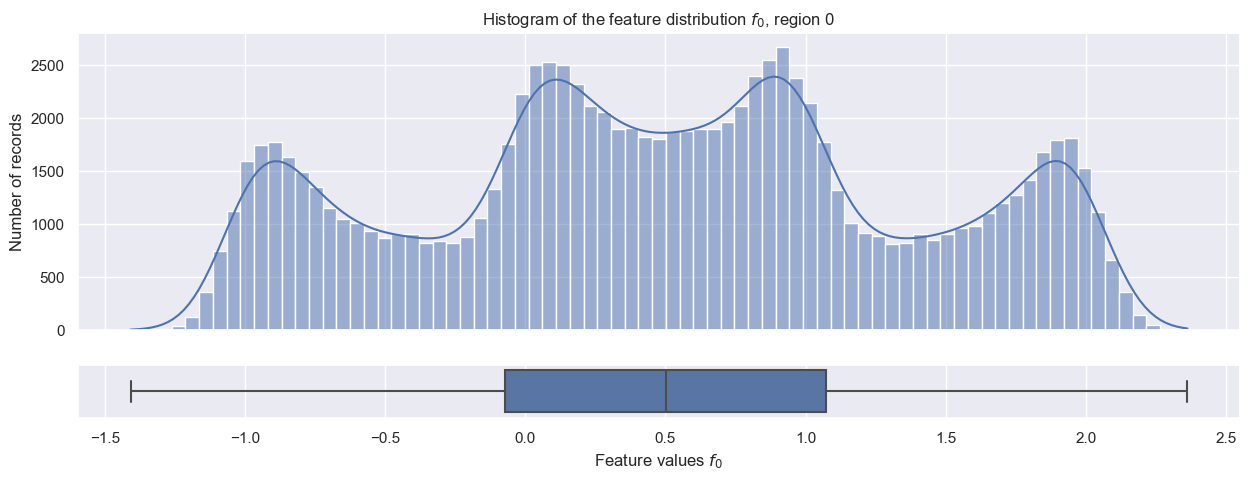

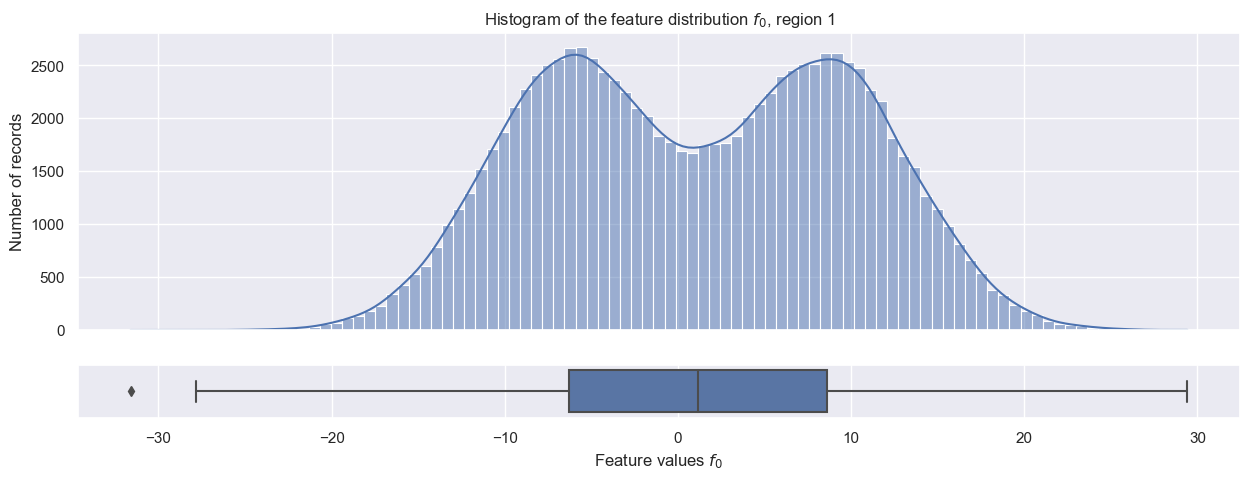

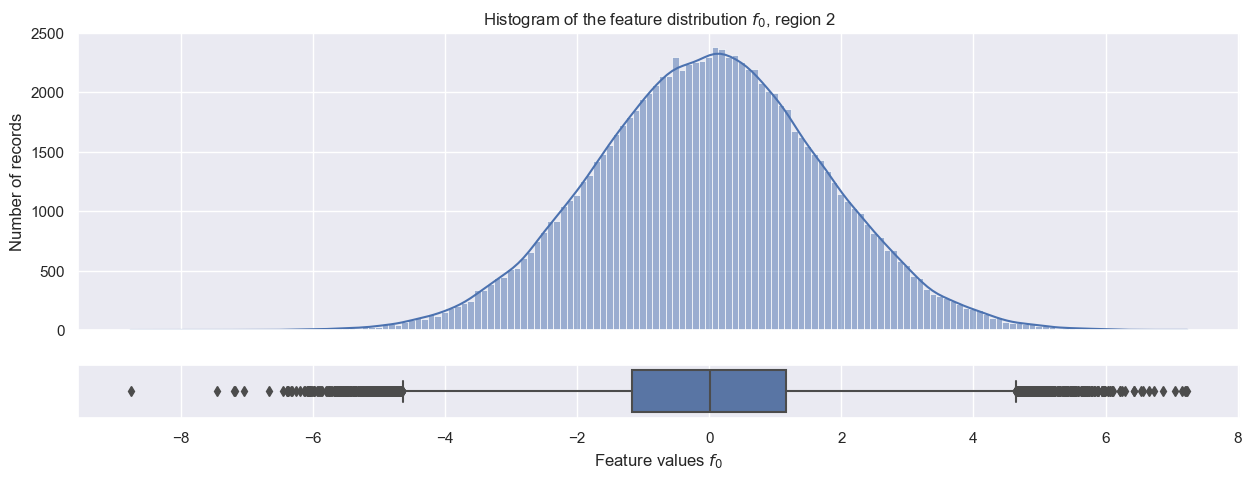

In [17]:
eda('f0', 'f_0')

The distribution of the feature for different regions is very different. For all three regions, the values of the mean or median are close to the range 0-1. However, the scope of data in the regions is different
The nature of the distributions also differs. If the distribution for region 2 is similar to normal, then the distribution of the trait in the first has 2 pronounced peaks, and the distribution in the zero region has four pronounced peaks.

Feature ***f1***


Parametr f1 in dataframe df0:


,f1
count,100000.000000
mean,0.250143
std,0.504433
min,-0.848218
25%,-0.200881
50%,0.250252
75%,0.700646
max,1.343769


Parametr f1 in dataframe df1:


,f1
count,100000.000000
mean,-4.796579
std,5.119872
min,-26.358598
25%,-8.267985
50%,-4.813172
75%,-1.332816
max,18.734063


Parametr f1 in dataframe df2:


,f1
count,100000.000000
mean,-0.002081
std,1.730417
min,-7.084020
25%,-1.174820
50%,-0.009482
75%,1.163678
max,7.844801


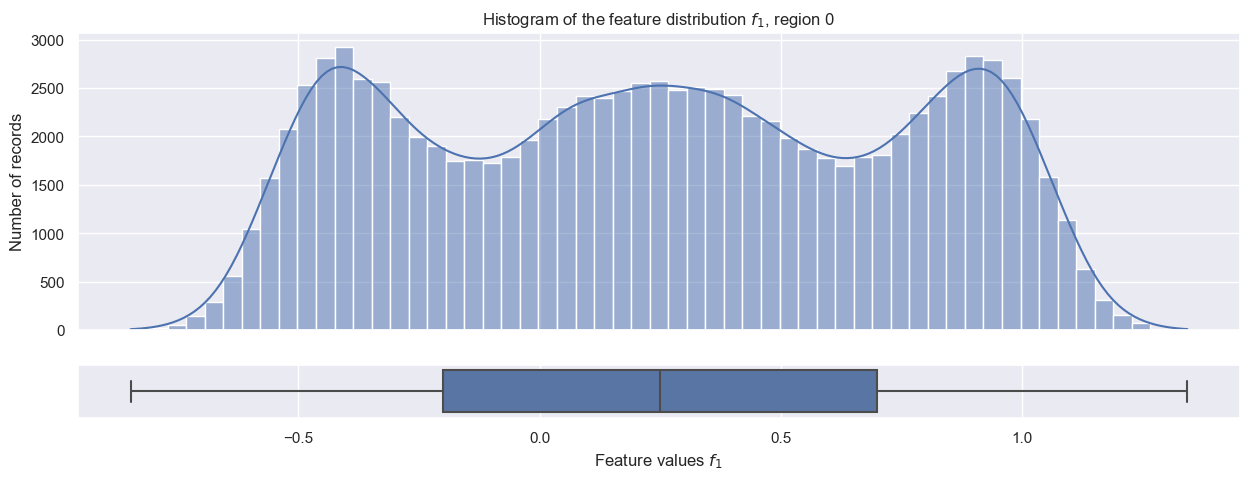

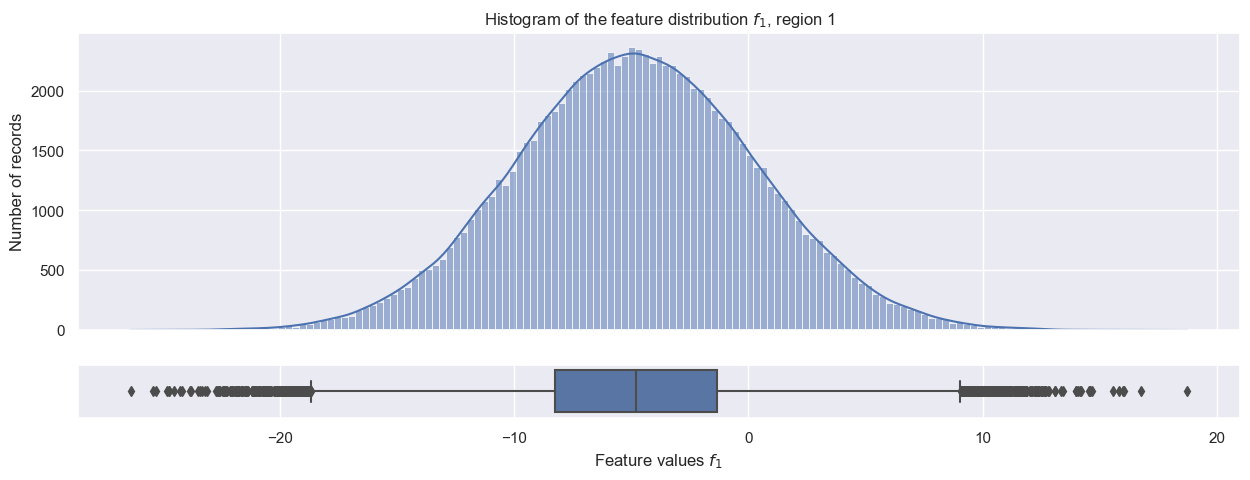

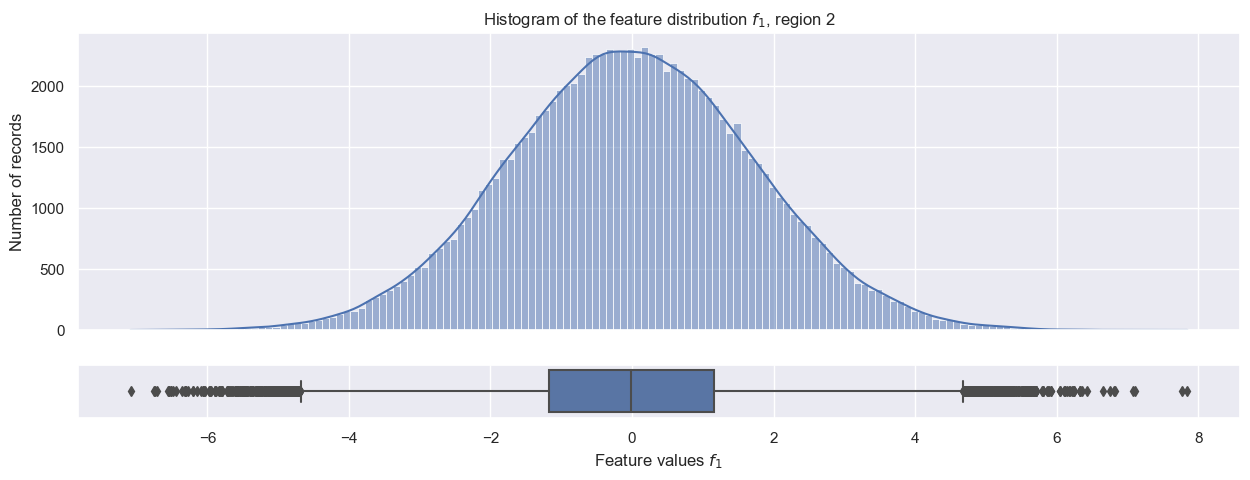

In [18]:
eda('f1', 'f_1')

The distribution of the trait for different regions is also very different. For regions 0 and 2, the mean or median values are close to zero, but for region 1 they are close to minus five. The scope of data varies in the regions.

The nature of the distributions varies by region. For regions 1 and 2, the distribution is similar to normal, but there are three pronounced peaks in the distribution for region 0.

eda('f2', 'f_2')

Parametr f2 in dataframe df0:


,f2
count,100000.000000
mean,2.502647
std,3.248248
min,-12.088328
25%,0.287748
50%,2.515969
75%,4.715088
max,16.003790


Parametr f2 in dataframe df1:


,f2
count,100000.000000
mean,2.494541
std,1.703572
min,-0.018144
25%,1.000021
50%,2.011479
75%,3.999904
max,5.019721


Parametr f2 in dataframe df2:


,f2
count,100000.000000
mean,2.495128
std,3.473445
min,-11.970335
25%,0.130359
50%,2.484236
75%,4.858794
max,16.739402


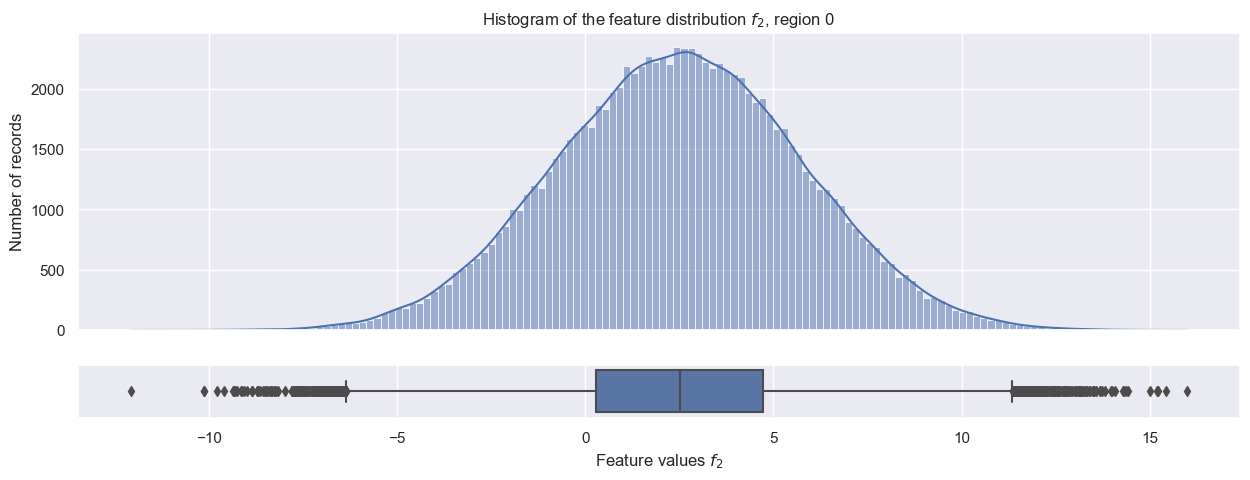

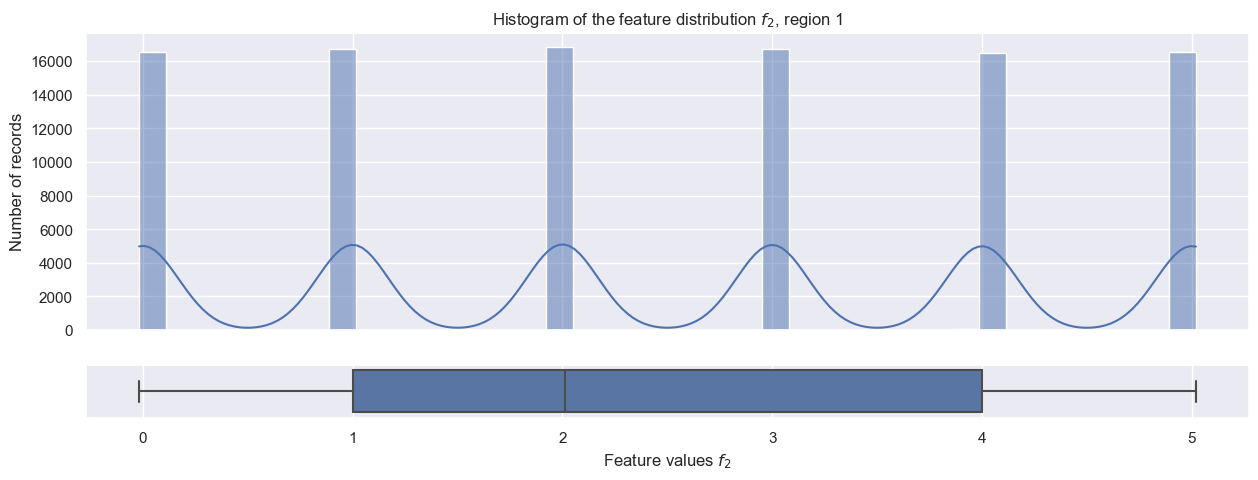

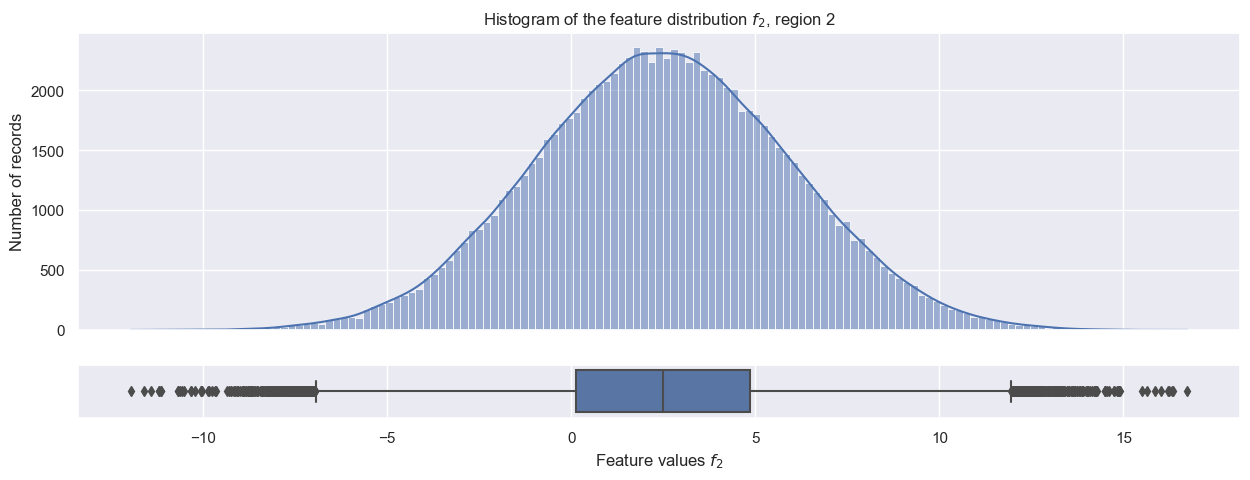

In [19]:
eda('f2', 'f_2')

The distributions of the trait for regions 0 and 2 do not differ much: they are similar to normal ones with an average of about 2.5 and similar standard deviations. However, in region 1, the nature of the distribution is clearly different: the data are grouped around the values 0, 1 ... 5.

**Volume of stocks**

Parametr product in dataframe df0:


,product
count,100000.000000
mean,92.500000
std,44.288691
min,0.000000
25%,56.497507
50%,91.849972
75%,128.564089
max,185.364347


Parametr product in dataframe df1:


,product
count,100000.000000
mean,68.825000
std,45.944423
min,0.000000
25%,26.953261
50%,57.085625
75%,107.813044
max,137.945408


Parametr product in dataframe df2:


,product
count,100000.000000
mean,95.000000
std,44.749921
min,0.000000
25%,59.450441
50%,94.925613
75%,130.595027
max,190.029838


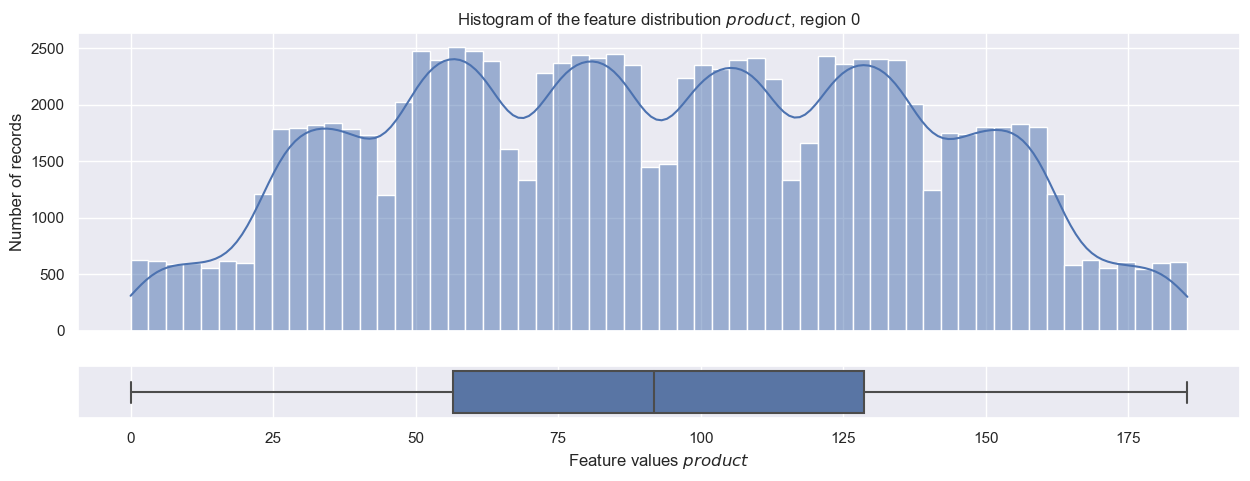

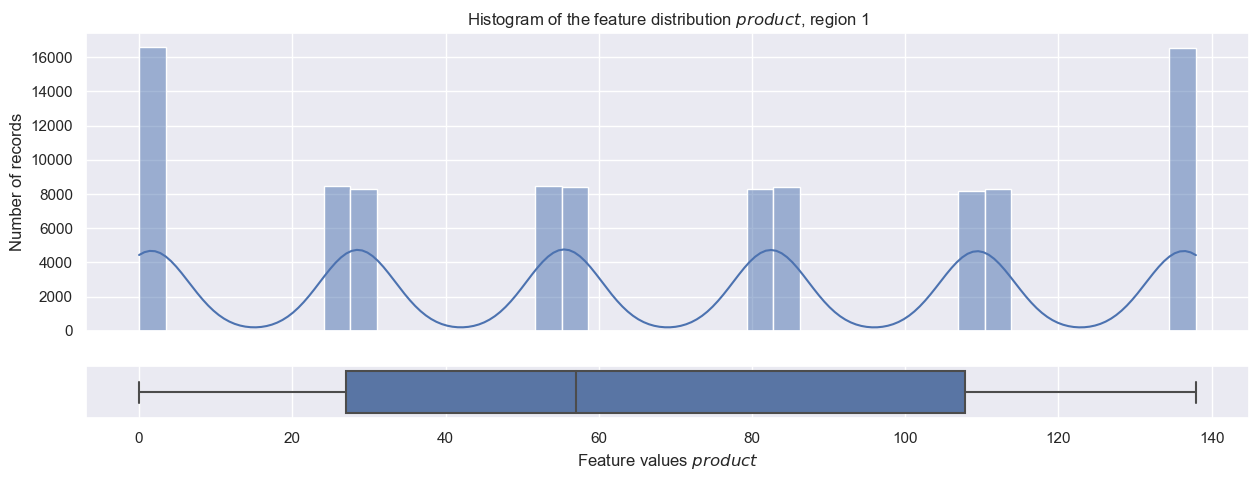

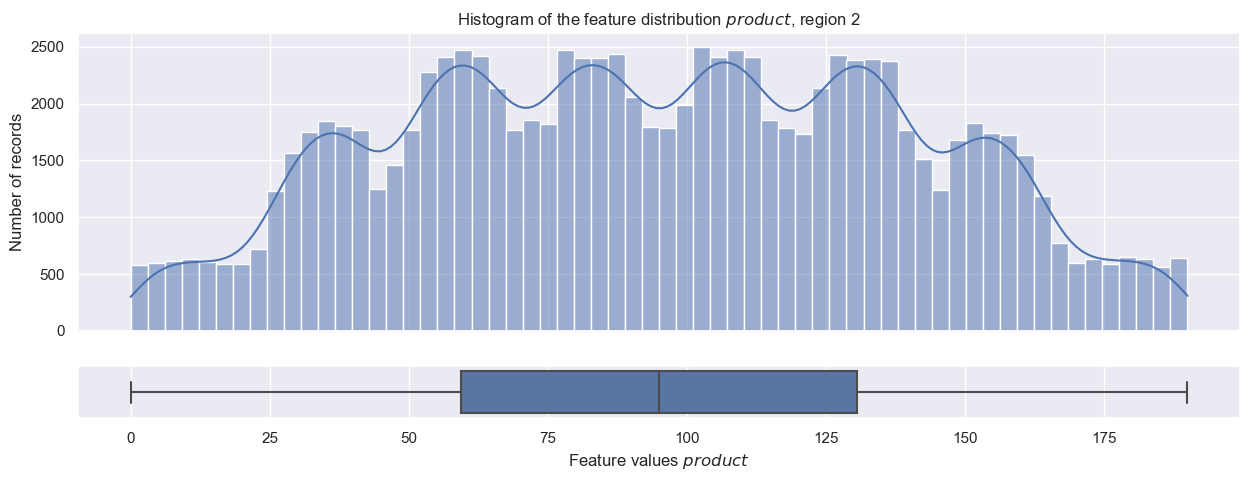

In [20]:
eda('product', 'product')

For all three regions, the distribution of inventory volumes differs from normal. Peaks of values can be observed in each region on the scattering diagram, in the first region they are most pronounced.

Perhaps such distributions are due to the fact that characteristic sub-regions can be distinguished in the regions, the average values for which look like peaks on the distributions.

**Матрицы корреляций**

In [22]:
df_0_ = df_0.drop(['id'], axis=1)
df_1_ = df_1.drop(['id'], axis=1)
df_2_ = df_2.drop(['id'], axis=1)
corr0 = df_0_.corr()
corr1 = df_1_.corr()
corr2 = df_2_.corr()

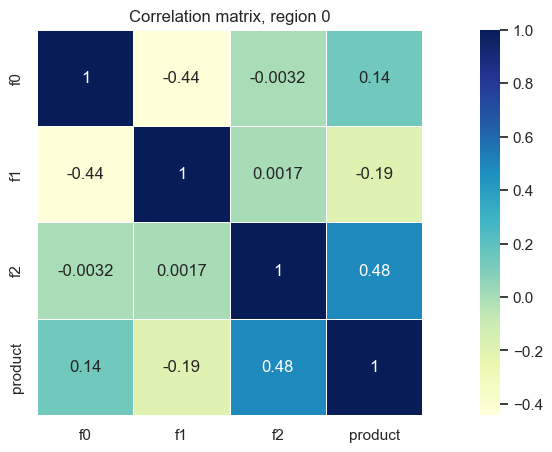

In [23]:
sns.heatmap(data=corr0, square=True, cmap="YlGnBu", linewidths=.5, annot=True)\
.set(title='Correlation matrix, region 0');

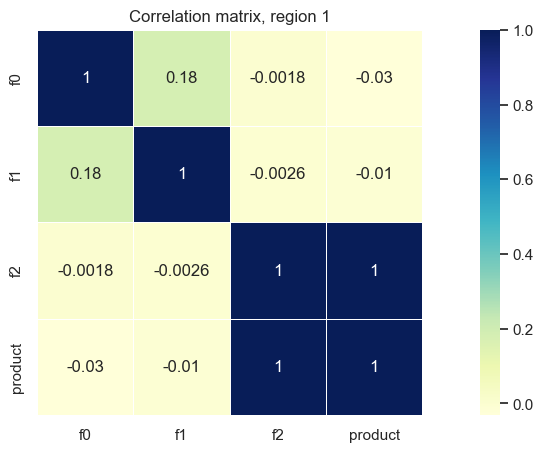

In [24]:
sns.heatmap(data=corr1, square=True, cmap="YlGnBu", linewidths=.5, annot=True)\
.set(title='Correlation matrix, region 1');

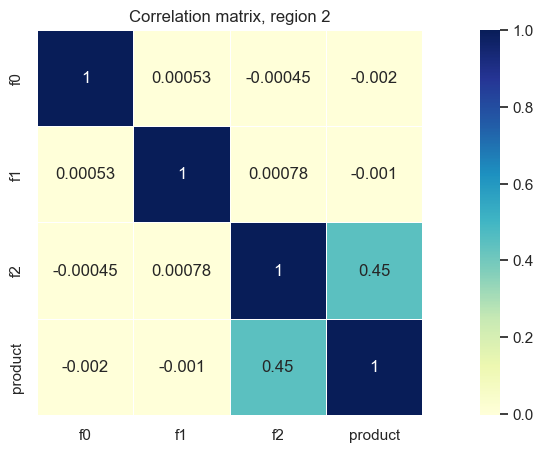

In [25]:
sns.heatmap(data=corr2, square=True, cmap="YlGnBu", linewidths=.5, annot=True)\
.set(title='Correlation matrix, region 2');

For regions 0 and 2, there is no strong correlation between the features. Some correlation is observed only between the attribute and the volume of stocks (the values of the Pearson correlation coefficient are 0.48 and 0.45).

However, for region 1, there is a very strong correlation between the attribute and the volume of reserves (Pearson correlation coefficient 1). This is suspicious, perhaps an error has crept into the data. Let's build a separate graph of the dependence of inventory volumes on the attribute for the first region.

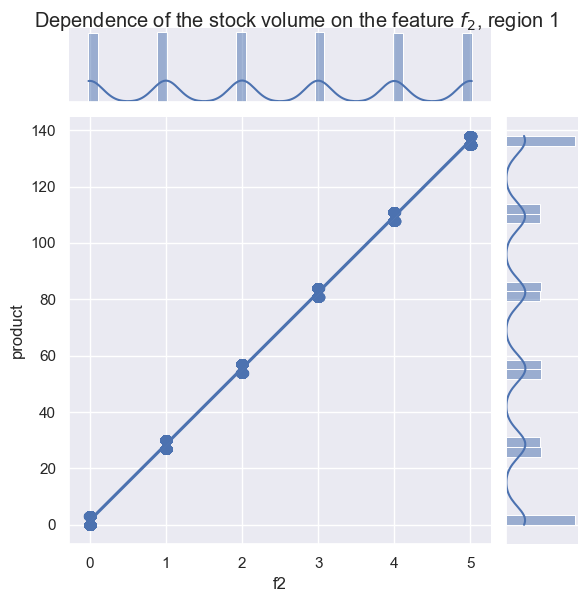

In [26]:
sns.jointplot(data=df_1, x='f2', y='product', kind='reg')
plt.suptitle('Dependence of the stock volume on the feature $f_2$, region 1', y=1)
plt.show()

For the purpose of further calculations of oil reserves and profit calculation, we will select the target and other features for each dataset, as well as divide the training and validation samples.

In [27]:
features_df_0 = df_0.drop(['product','id'], axis = 1)
target_df_0 = df_0['product']

features_df_1 = df_1.drop(['product','id'], axis = 1)
target_df_1 = df_1['product']

features_df_2 = df_2.drop(['product','id'], axis = 1)
target_df_2 = df_2['product']

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_df_0, target_df_0, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_df_1, target_df_1, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_df_2, target_df_2, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

## Model training and validation

In [28]:
model_0 = LinearRegression()
model_0.fit(features_train_0 , target_train_0) 

model_1 = LinearRegression()
model_1.fit(features_train_1 , target_train_1)

model_2 = LinearRegression()
model_2.fit(features_train_2 , target_train_2)

predictions_valid_0 = model_0.predict(features_valid_0)
predictions_valid_1 = model_1.predict(features_valid_1)
predictions_valid_2 = model_2.predict(features_valid_2)

predictions_valid_0_m = pd.Series(target_valid_0.mean(), index=target_valid_0.index) #среднее значение целевого признака 
predictions_valid_1_m = pd.Series(target_valid_1.mean(), index=target_valid_1.index) #среднее значение целевого признака
predictions_valid_2_m = pd.Series(target_valid_2.mean(), index=target_valid_2.index) #среднее значение целевого признака

rmse_0 = (mean_squared_error(target_valid_0, predictions_valid_0))**0.5
rmse_1 = (mean_squared_error(target_valid_1, predictions_valid_1))**0.5
rmse_2 = (mean_squared_error(target_valid_2, predictions_valid_2))**0.5

rmse_0_m = (mean_squared_error(target_valid_0, predictions_valid_0_m))**0.5
rmse_1_m = (mean_squared_error(target_valid_1, predictions_valid_1_m))**0.5
rmse_2_m = (mean_squared_error(target_valid_2, predictions_valid_2_m))**0.5

print(f'Region_0: product = {predictions_valid_0.mean()}; rmse = {rmse_0}; rmse_mean = {rmse_0_m}')
print(f'Region_1: product = {predictions_valid_1.mean()}; rmse = {rmse_1}; rmse_mean = {rmse_1_m}')
print(f'Region_2: product = {predictions_valid_2.mean()}; rmse = {rmse_2}; rmse_mean = {rmse_2_m}')

Region_0: product = 92.59256778438035; rmse = 37.5794217150813; rmse_mean = 44.28602687855358
Region_1: product = 68.72854689544602; rmse = 0.893099286775617; rmse_mean = 46.0212449226281
Region_2: product = 94.96504596800489; rmse = 40.02970873393434; rmse_mean = 44.902084376898294


**Conclusion**
1. The average reserve of predicted raw materials at deposits No. 0 and No. 2.
2. Field No. 1 has the lowest average reserve, with the lowest rsme value for the predicted model. Hence, at this stage, it can be assumed that this deposit may be less risky for investments.

## Profit calculation

According to the conditions of the problem, it is known that:

- The development budget is 10 billion rubles.
- The income from each unit of product is 450 thousand per thousand barrels.

We will enter the constant data and calculate the minimum average amount of product in the deposit of the region sufficient for development.

In [29]:
BUDGET = 10000 # budget, mln. rub
POINT_PER_BUDGET = 200 # places
PRODUKT_PRICE = 0.45 # profitability of one unit of a barrel in million rubles

budget_per_point = BUDGET/POINT_PER_BUDGET # budget for the development of one well
product_value_point = budget_per_point/PRODUKT_PRICE # the required volume of the well, sufficient for development

print(f'Budget for the development of one well: {budget_per_point} mln. rub')
print(f'The required volume of the well, sufficient for development: {product_value_point:0.3f} 000. barrels')

Budget for the development of one well: 50.0 mln. rub
The required volume of the well, sufficient for development: 111.111 000. barrels


**Conclusion**

According to the results of calculations, it is clear that 50 million rubles are required for the development of the 1st well.

The required volume of oil reserves in the zone of one well should be about 111 thousand barrels.
It should be noted that the required volume is much higher than the predicted values according to the model.

Given that theory and practice may differ greatly, we will choose the most suitable deposit further with a risk assessment.

At this stage, we will prepare a profit calculation function for well development.

In [30]:
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)

predictions_valid_0 = pd.Series(predictions_valid_0).reset_index(drop=True)
predictions_valid_1 = pd.Series(predictions_valid_1).reset_index(drop=True)
predictions_valid_2 = pd.Series(predictions_valid_2).reset_index(drop=True)

def profit(target, predictions, count):
    probs_sorted = predictions.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (0.45 * selected.sum()) - BUDGET

## Calculation of profit and risks

In [31]:
df_0_profit = profit(target_valid_0, predictions_valid_0, 200)
df_0_profit

3320.8260431398503

In [32]:
df_1_profit = profit(target_valid_1, predictions_valid_1, 200)
df_1_profit

2415.086696681512

In [33]:
df_2_profit = profit(target_valid_2, predictions_valid_2, 200)
df_2_profit

2710.3499635998323

The best profit results are shown by the place of birth No. 0 (13,310,826.04 million rubles) and No. 2 (12,700,349.96 million rubles).

To assess the risks and profits for each region, we will use the bootstrap technique.

In [35]:
state = np.random.RandomState(12345)


values_0 = []
values_1 = []
values_2 = []
for i in range(1000):
    target_subsample_0 = target_valid_0.sample(n=500, replace=True, random_state=state)
    probs_subsample_0 = pd.Series(predictions_valid_0[target_subsample_0.index])
    values_0.append(profit(target_subsample_0, 
                          probs_subsample_0,
                          200))    
    
for i in range(1000):
    target_subsample_1 = target_valid_1.sample(n=500, replace=True, random_state=state)
    probs_subsample_1 = pd.Series(predictions_valid_1[target_subsample_1.index])
    values_1.append(profit(target_subsample_1, 
                          probs_subsample_1,
                          200))
    
for i in range(1000):
    target_subsample_2 = target_valid_2.sample(n=500, replace=True, random_state=state)
    probs_subsample_2 = pd.Series(predictions_valid_2[target_subsample_2.index])
    values_2.append(profit(target_subsample_2, 
                          probs_subsample_2,
                          200))        
    
values_0 = pd.Series(values_0)
lower_0 = values_0.quantile(0.025)
upper_0 = values_0.quantile(0.975)
mean_0 = values_0.mean()
#confidence_interval_0 = st.t.interval(0.95, len(values_0)-1, loc = values_0.mean(), scale =values_0.sem())
sum_0 = values_0.sum()

values_1 = pd.Series(values_1)
lower_1 = values_1.quantile(0.025)
upper_1 = values_1.quantile(0.975)
mean_1 = values_1.mean()
#confidence_interval_1 = st.t.interval(0.95, len(values_1)-1, loc = values_1.mean(), scale =values_1.sem())
sum_1 = values_1.sum()

values_2 = pd.Series(values_2)
lower_2 = values_2.quantile(0.025)
upper_2 = values_2.quantile(0.975)
mean_2 = values_2.mean()
#confidence_interval_2 = st.t.interval(0.95, len(values_2)-1, loc = values_2.mean(), scale =values_2.sem())
sum_2 = values_2.sum()

def calc_risk(values_): 
    loss_point = 0      
    for i in range(len(values_)):
        if values_[i] < 0:
            loss_point += 1
    risk = loss_point/len(values_)
    return risk


print("Average profit, Region №0:", mean_0)
print("Confidence interval(Region №0):", lower_0, '-',upper_0)
print("Risk of losses, (Region №0):", calc_risk(values_0))
print("Total profit:", sum_0)
print()
print("Average profit, Region №1:", mean_1)
print("Confidence interval(Region №1):", lower_1, '-',upper_1)
print("Risk of losses, (Region №1):", calc_risk(values_1))
print("Total profit:", sum_1)
print()
print("Average profit, Region №2:", mean_2)
print("Confidence interval(Region №2):", lower_2, '-',upper_2)
print("Risk of losses (Region №2):", calc_risk(values_2))
print("Total profit:", sum_2)


Average profit, Region №0: 425.9385269105927
Confidence interval(Region №0): -102.09009483793592 - 947.976353358369
Risk of losses, (Region №0): 0.06
Total profit: 425938.5269105927

Average profit, Region №1: 518.2594936973252
Confidence interval(Region №1): 128.12323143308453 - 953.6129820669079
Risk of losses, (Region №1): 0.003
Total profit: 518259.49369732523

Average profit, Region №2: 420.19400534405037
Confidence interval(Region №2): -115.85260916001138 - 989.6299398445756
Risk of losses (Region №2): 0.062
Total profit: 420194.00534405035


## Results of the research

The best Region to invest in development will be No. 2, since:

1) It has the highest average profit: 518 million rubles.

2) It has the highest total profit: 518,259 million rubles.

3) Absence of losses (negative profit) in the confidence interval

4) The lowest risk of losses: 0.3%.